# Data Prep for Fermi/GBM Solar Flares

We currently don't have access to the Fermi/GBM and GOES data from the [Inglis paper](https://arxiv.org/abs/1610.07454), so we'll make do. 

For now, I've downloaded the data in their Figure 2 from the Fermi/GBM ftp archive by looking up the observation times in the [Fermi/GBM solar flare catalogue](https://hesperia.gsfc.nasa.gov/fermi/gbm/qlook/fermi_gbm_flare_list.txt) and then downloaded the right burst trigger. The archive also gives the detectors with angles closest to the sun, so we'll use that for now.

Inglis et al use CTIME data, and they bin it to a 1-second time resolution. We might want to do the same. 

Right now, we need to (1) load the right CTIME data files, (2) combine the correct detectors and (3) cut the light curve correctly. 

In [ ]:
# plotting
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

# numerics
import numpy as np

# FITS reading
from astropy.io import fits

# power spectral stuff
from stingray import Lightcurve, Powerspectrum

Here are the data sets we're going to consider right now:


| Date | Time | Trigger No | Detectors | models |
|------|------|------------|-----------|--------|
| 2011-09-23 | 23:47:34 | 110923993 | n0, n1, n3, n5 | 2 models compete | 
| 2012-07-04 | 04:27:33 | 120704187 | n5, n3, n1, n4 | strongly favours broken power law |
| 2012-10-22 | 18:44:00 | 121022782 | n5, n3, n1, n0 | strongly favours PL + Lorentzian | 
| 2013-04-05 | 17:36:34 | 130405735 | n0, n1, n3, n5 | 2 models compete | 
| 2014-03-11 | 11:59:35 | 140311501 | n1, n3, n5, n0 | 2 models compete |


Let's start with the 2012-10-22 flare. First, let's make sure we can access the right directory and burst.

In [2]:
# directory with the data
datadir = "/Users/danielahuppenkothen/work/data/solarflares/bn121022782/current/"

# trigger ID
burstid = "121022782"

# detectors
det = [0, 1, 3, 5]

The data is in a file in FITS format, which we can read with `astropy.io.fits`. 

In [3]:
# construct file name
f = "glg_ctime_n" + str(det[0]) + "_bn" + str(burstid) + "_v00.pha"

hdulist = fits.open(datadir+f)

Let's display some info about that file:

In [4]:
hdulist.info()

Filename: /Users/danielahuppenkothen/work/data/solarflares/bn121022782/current/glg_ctime_n0_bn121022782_v00.pha
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      37   ()      
  1  EBOUNDS     BinTableHDU     58   8R x 3C   [1I, 1E, 1E]   
  2  SPECTRUM    BinTableHDU     72   14065R x 5C   [8I, 1E, 1I, 1D, 1D]   
  3  GTI         BinTableHDU     44   1R x 2C   [1D, 1D]   


The zeroth extension has no data, just a header with lots of meta-data about the observation.

In [5]:
hdulist[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CREATOR = 'GBM_SCI_Reader.pl v1.19' / Software and version creating file        
FILETYPE= 'PHAII   '           / Name for this type of FITS file                
FILE-VER= '1.0.0   '           / Version of the format for this filetype        
TELESCOP= 'GLAST   '           / Name of mission/satellite                      
INSTRUME= 'GBM     '           / Specific instrument used for observation       
DETNAM  = 'NAI_00  '           / Individual detector name                       
OBSERVER= 'Meegan  '        

The first extension is called `EBOUNDS`, which tells us that there are energy bounds in there. 
Energy bounds refer to the *energy* of the *photon*, because X-ray astronomers measure photon energy rather than wavelength (which is basically defined as $E = hc/\lambda$). 

Fermi/GBM has three types of data: *CTIME* data has a good time resolution but a poor energy resolution (it sorts all photons into eight broad bins, *CSPEC* data has poor time resolution but good energy resolution (this is for spectral studies mainly), and *TTE* data (or time-tagged event data) contains records of *all* photons recorded with their respective energy. 

Here, we're looking at *CTIME* data, so the *EBOUNDS* extension contains the boundaries for the energy bins that the photons got sorted into.

In [6]:
hdulist[1].data

FITS_rec([(0,    4.52515221,    11.81438446),
       (1,   11.81438446,    26.9386692 ),
       (2,   26.9386692 ,    50.35152054),
       (3,   50.35152054,   101.62812042),
       (4,  101.62812042,   293.84265137),
       (5,  293.84265137,   537.77600098),
       (6,  537.77600098,   983.27990723),
       (7,  983.27990723,  2000.        )], 
      dtype=(numpy.record, [('CHANNEL', '>i2'), ('E_MIN', '>f4'), ('E_MAX', '>f4')]))

We're going to want to look mainly at 4-25 keV, so bins 0 and 1. 

The second extension contains the actual time series (disregard that it's called *SPECTRUM*, this is just a FITS file convention):

In [7]:
data = hdulist[2].data

In [8]:
data

FITS_rec([ ([     0,     74,     59,     46,     46,      9,      8,     17],  0.25513637, 0, 372623362.52564001, 372623362.78163999),
       ([     0,     77,     38,     42,     52,     15,     12,     24],  0.25517634, 0, 372623362.78163999, 372623363.03765398),
       ([     0,     77,     46,     36,     29,     18,     12,     26],  0.25511828, 0, 372623363.03765398, 372623363.29365396),
       ...,
       ([     0,      0,      0,      0,      0,      0,      0,      0],  0.25599998, 0, 372625168.16297001, 372625168.41896999),
       ([     0,      0,      0,      0,      0,      0,      0,      0],  0.25600004, 0, 372625168.41896999, 372625168.67497003),
       ([     0,      0,      0,      0,      0,      0,      0,      0],  0.08779198, 0, 372625168.67497003, 372625168.76276201)], 
      dtype=(numpy.record, [('COUNTS', '>i2', (8,)), ('EXPOSURE', '>f4'), ('QUALITY', '>i2'), ('TIME', '>f8'), ('ENDTIME', '>f8')]))

We're going to extract the *COUNTS* field and the *TIME* field:

In [9]:
counts = data.field("COUNTS")
time = data.field("TIME")
time = time - time[0]

We're only interested in the sum of the zeroth and first energy bin, so let's extract those and add the columns together:

In [10]:
counts = np.sum(counts[:,:2], axis=1)

Let's also look at the lengths of each bin:

In [11]:
dt = np.diff(time)

Now we can plot a first light curve!

<IPython.core.display.Javascript object>


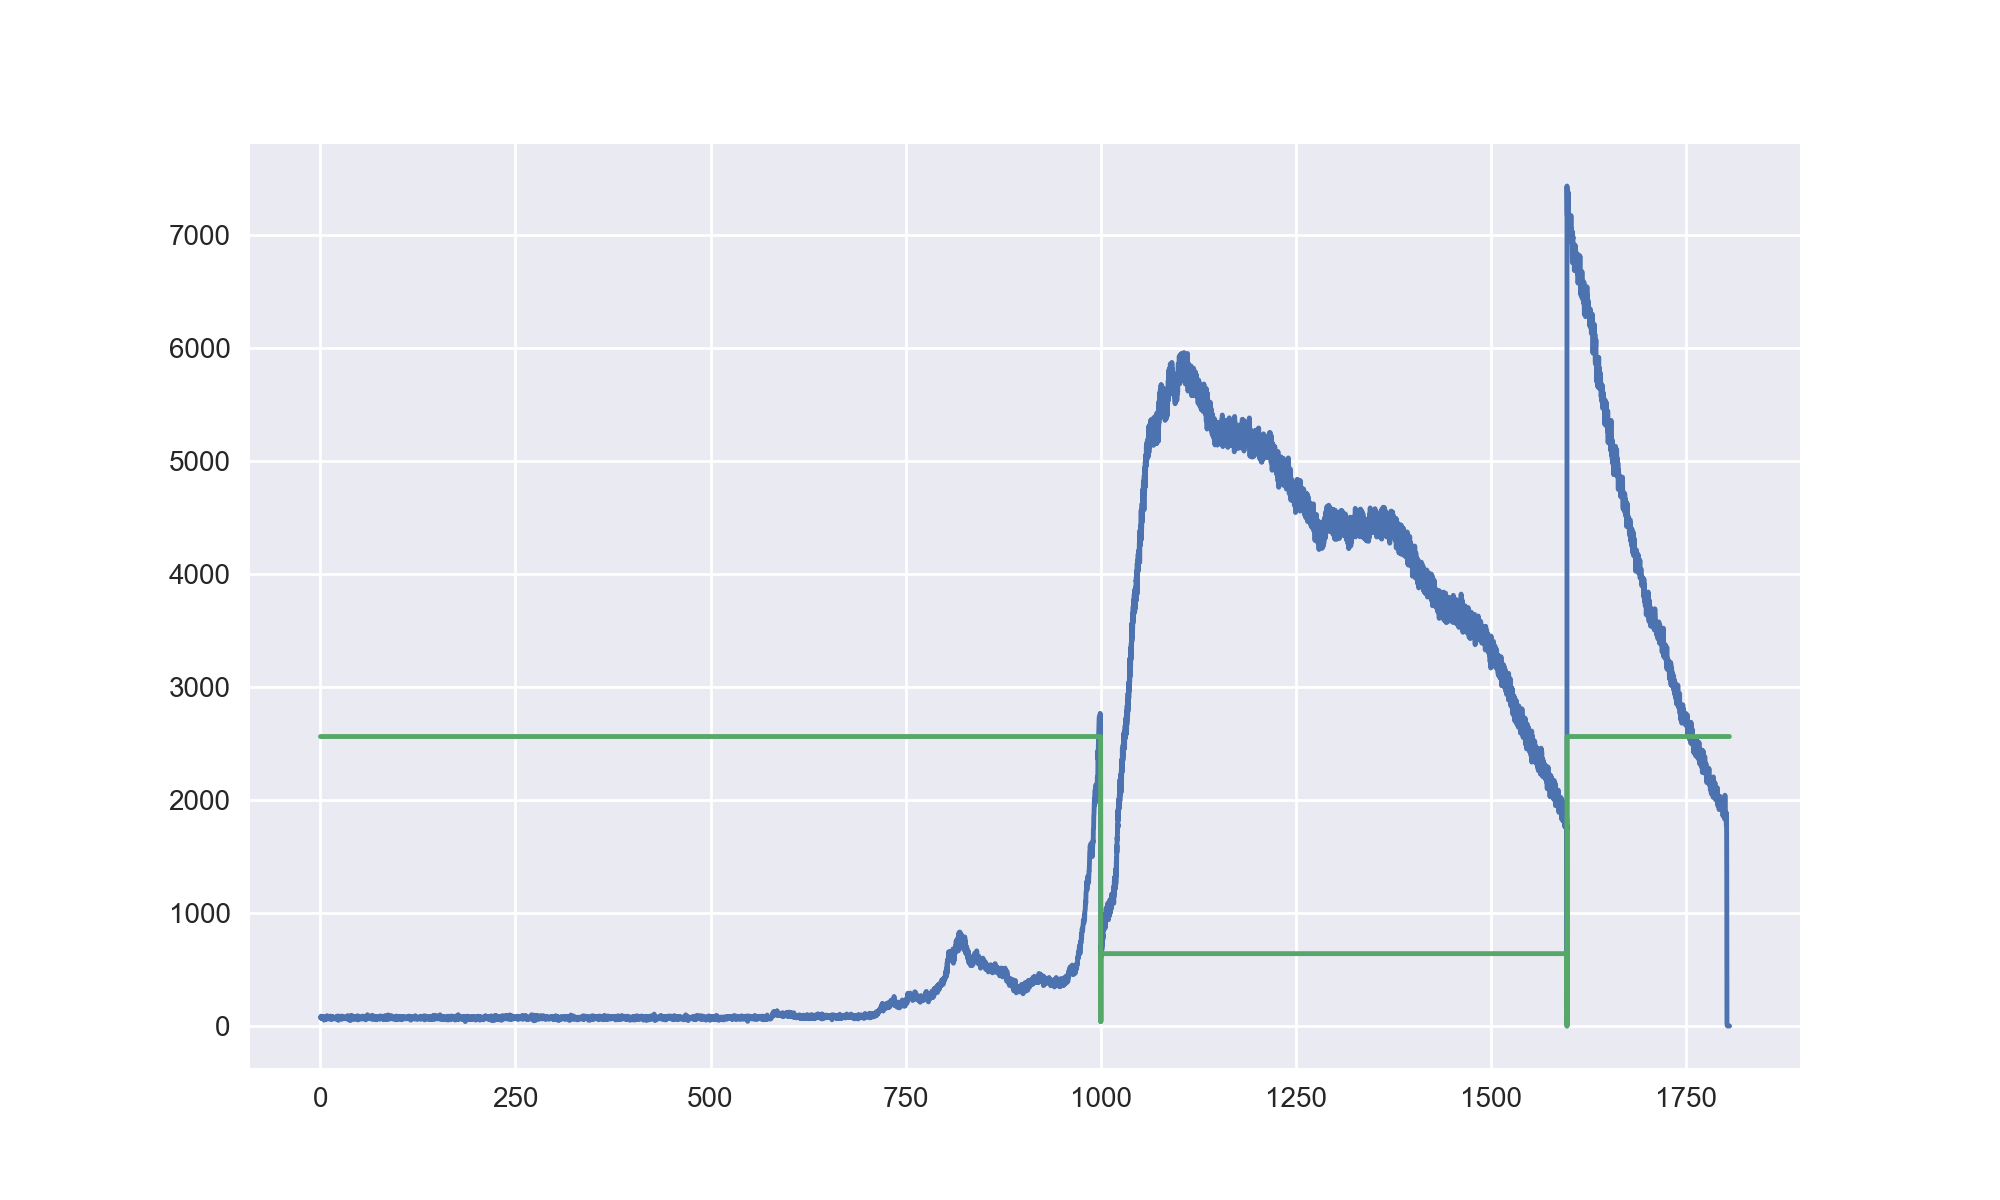

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(time, counts)
plt.plot(time[:-1], dt*10000)

Okay, that looks pretty weird. The big edges are because the time resolution of the data changes for part of it. For the brightest parts of the flare, the time resolution increases from 0.256 seconds to 64ms, which means that there are fewer photons per bin, so it looks like the flare has gotten fainter. 


Before we rebin the data, let's write a simple function that loads the data and returns it in a more readable format:

In [14]:
def load_data(datadir, burstid, detectors):
    
    counts_all = []
    for d in detectors:
        
        # construct file name
        f = "glg_ctime_n" + str(d) + "_bn" + str(burstid) + "_v00.pha"

        # open data file
        hdulist = fits.open(datadir+f)
        
        data = hdulist[2].data
        counts = data.field("COUNTS")
        time = data.field("TIME")
        time = time - time[0]
        dt = np.diff(time)
        
        hdulist.close()
                
        counts_all.append(counts[:,1])
        
    counts_all = np.array(counts_all)
    counts_all = np.sum(counts_all, axis=0)
    
    return time, dt, counts_all

In [15]:
time, dt, counts = load_data(datadir, burstid, detectors=det)

<IPython.core.display.Javascript object>


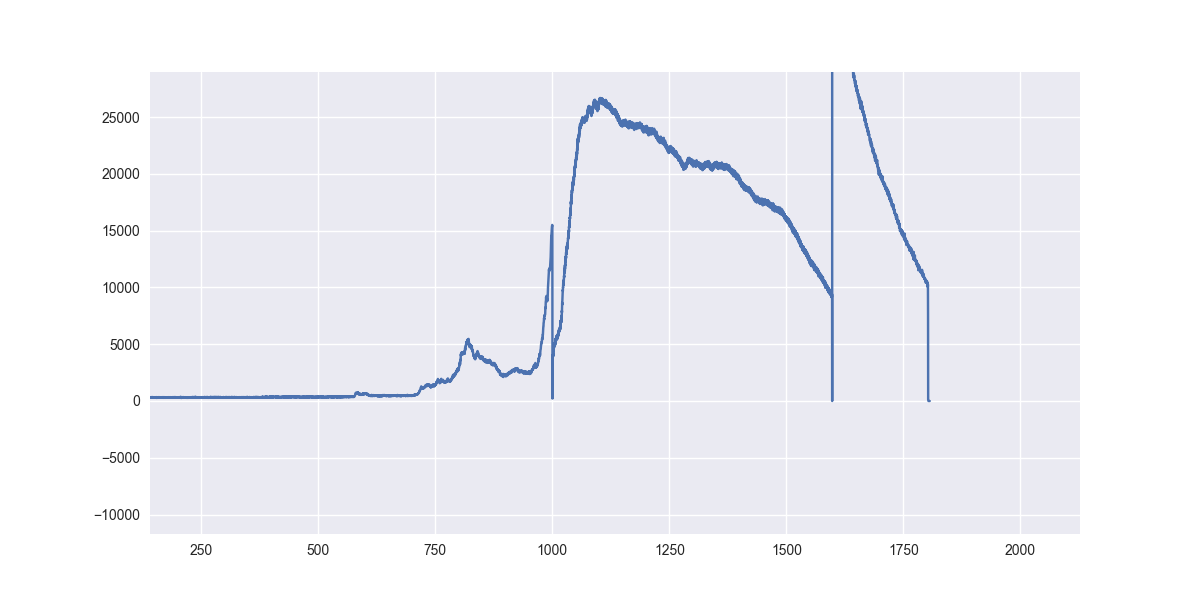

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(time-time[0], counts)

Before we do anything else: the first 700 seconds or so are pretty flat, so let's delete those:

In [17]:
start_ind = time.searchsorted(670)

In [18]:
start_ind

2618

In [19]:
time = time[start_ind:]
counts = counts[start_ind:]
dt = dt[start_ind:]

Let's rebin the data so that the time resolution is the same everywhere. For this, we kind of have to chop the data up, rebin it, and piece it together again:

In [20]:
np.where(dt < 0.1)[0]

array([ 1289,  1290,  1291, ..., 10629, 10630, 10631])

In [21]:
dt_min_ind = np.where(dt < 0.1)[0][1]
dt_max_ind = np.where(dt < 0.1)[0][-2]

In [22]:
len(time[dt_max_ind:])

817

In [23]:
lc1 = Lightcurve(time[:dt_min_ind-1], counts[:dt_min_ind-1])
lc2 = Lightcurve(time[dt_min_ind+1:dt_max_ind-5], counts[dt_min_ind+1:dt_max_ind-5])
lc3 = Lightcurve(time[dt_max_ind+3:-15], counts[dt_max_ind+3:-15])

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


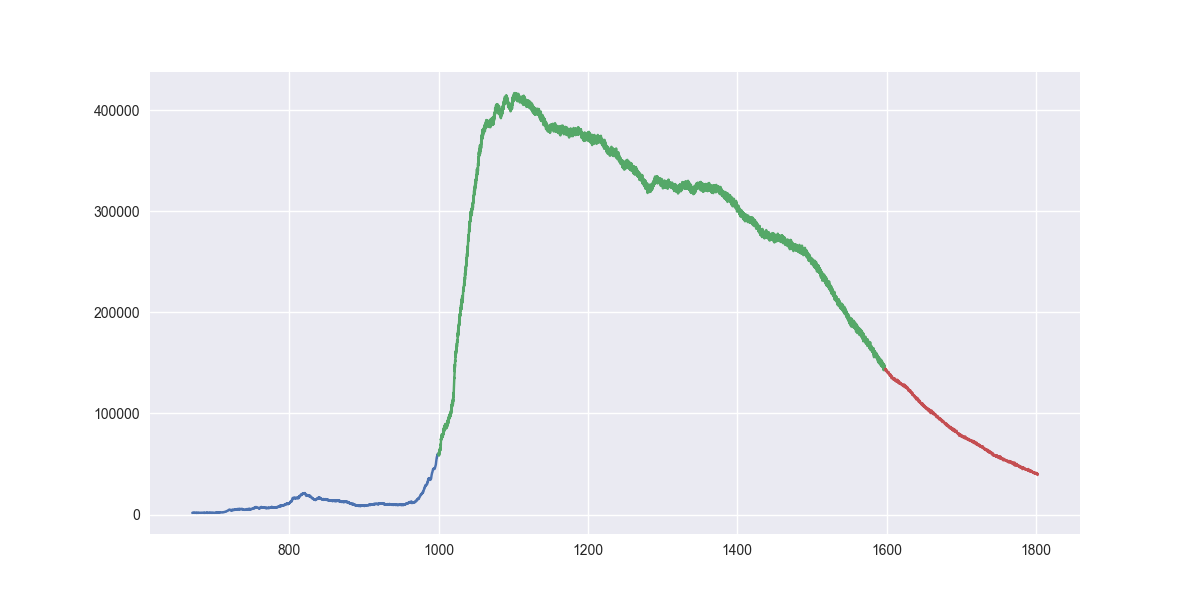

In [24]:
plt.figure(figsize=(12,6))
plt.plot(lc1.time, lc1.countrate)
plt.plot(lc2.time, lc2.countrate)
plt.plot(lc3.time, lc3.countrate)

This produces a warning, because in many cases, having an unevenly sampled time series isn't appropriate (in our case later, it might be, though). For now, let's go with an evenly sampled light curve for simplicity:

In [25]:
lc1bin = lc1.rebin(1.0)
lc2bin = lc2.rebin(1.0)
lc3bin = lc3.rebin(1.0)

<IPython.core.display.Javascript object>


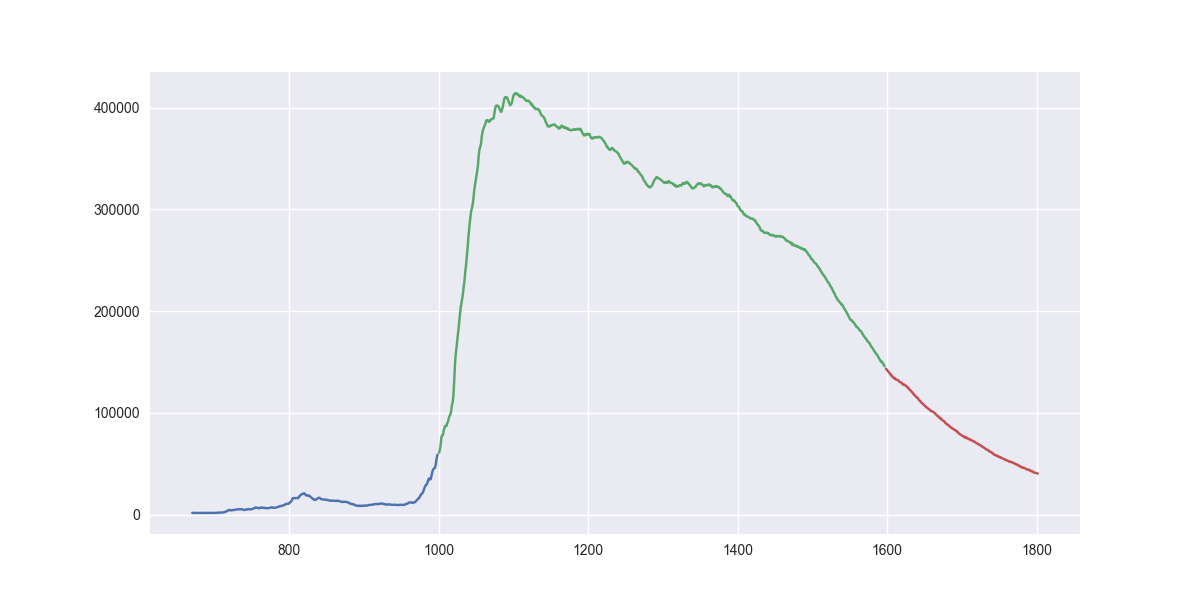

In [26]:
plt.figure(figsize=(12,6))
plt.plot(lc1bin.time, lc1bin.counts)
#plt.plot(lc2.time, lc2.countrate)
plt.plot(lc2bin.time, lc2bin.countrate)
plt.plot(lc3bin.time, lc3bin.counts)

In [27]:
lc = lc1bin.join(lc2bin)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [28]:
lc = lc.join(lc3bin)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


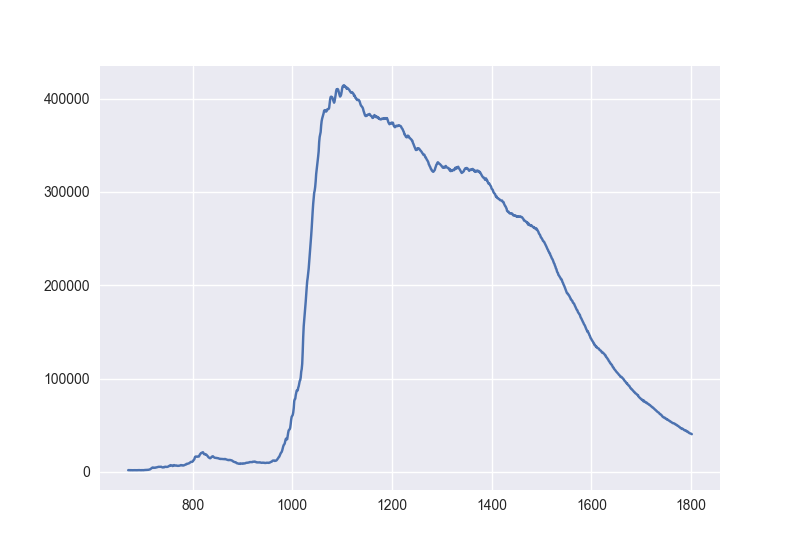

In [29]:
plt.figure()
plt.plot(lc.time, lc.counts)

Okay, so this is a huge pain. The times don't work *exactly*, but let's go on anyway for now. We might have to switch to TTE data after all.

Let's make a power spectrum for fun:


In [30]:
lc.gti = np.array([[lc.gti[0,0], lc.gti[-1,-1]]])

In [31]:
ps = Powerspectrum(lc)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


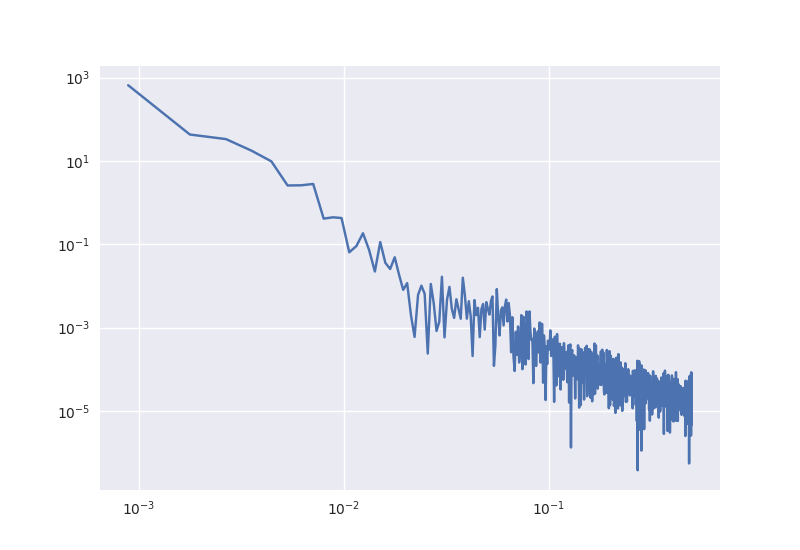

In [32]:
plt.figure()
plt.loglog(ps.freq, ps.power)

Well, let's save the data set to file for use:

In [33]:
np.savetxt("121022782_ctime_lc.txt", np.array([lc.time, lc.counts]).T)

### 2012-07-04 Flare

Let's try another flare, maybe with less funky data issues.

In [34]:
# directory with the data
datadir = "/Users/danielahuppenkothen/work/data/solarflares/bn120704187/current/"

# trigger ID
burstid = "120704187"

# detectors
det = [5, 3, 1, 4]

In [35]:
time, dt, counts = load_data(datadir, burstid, detectors=det)

In [36]:
time = time - time[0]

<IPython.core.display.Javascript object>


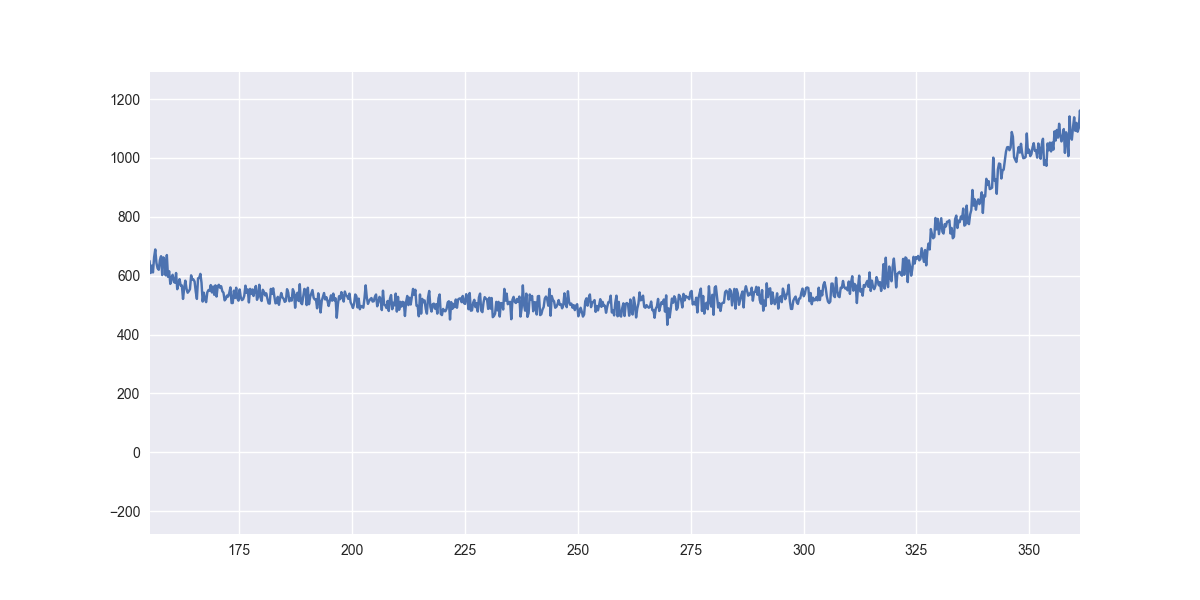

In [37]:
plt.figure(figsize=(12,6))
plt.plot(time, counts)

In [38]:
start_ind = time.searchsorted(300)
time = time[start_ind:]
counts = counts[start_ind:]
dt = dt[start_ind:]

In [39]:
dt_min_ind = np.where(dt < 0.1)[0][1]
dt_max_ind = np.where(dt < 0.1)[0][-1]

lc1 = Lightcurve(time[:dt_min_ind-3], counts[:dt_min_ind-3])
lc2 = Lightcurve(time[dt_min_ind:dt_max_ind-5], counts[dt_min_ind:dt_max_ind-5])
lc3 = Lightcurve(time[dt_max_ind+1:], counts[dt_max_ind+1:])


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [40]:
lc1.counts[-10:]

array([3904, 3943, 4112, 4094, 4330, 4434, 4621, 4949, 4879, 4939], dtype=uint64)

<IPython.core.display.Javascript object>


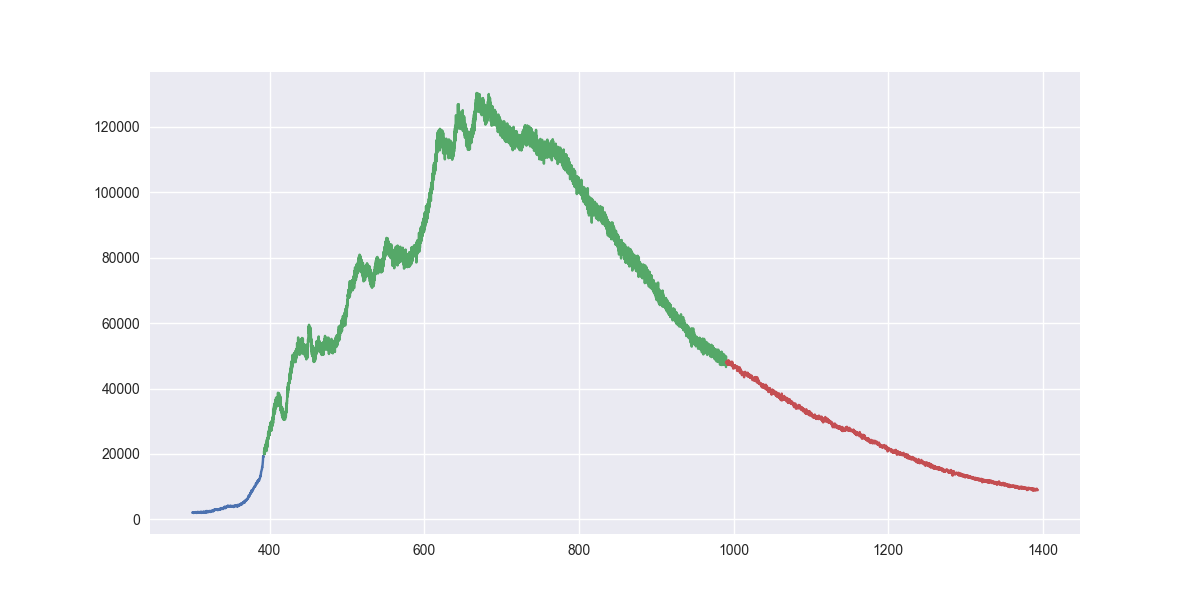

In [41]:

plt.figure(figsize=(12,6))
plt.plot(lc1.time, lc1.countrate)
plt.plot(lc2.time, lc2.countrate)
plt.plot(lc3.time, lc3.countrate)


<IPython.core.display.Javascript object>


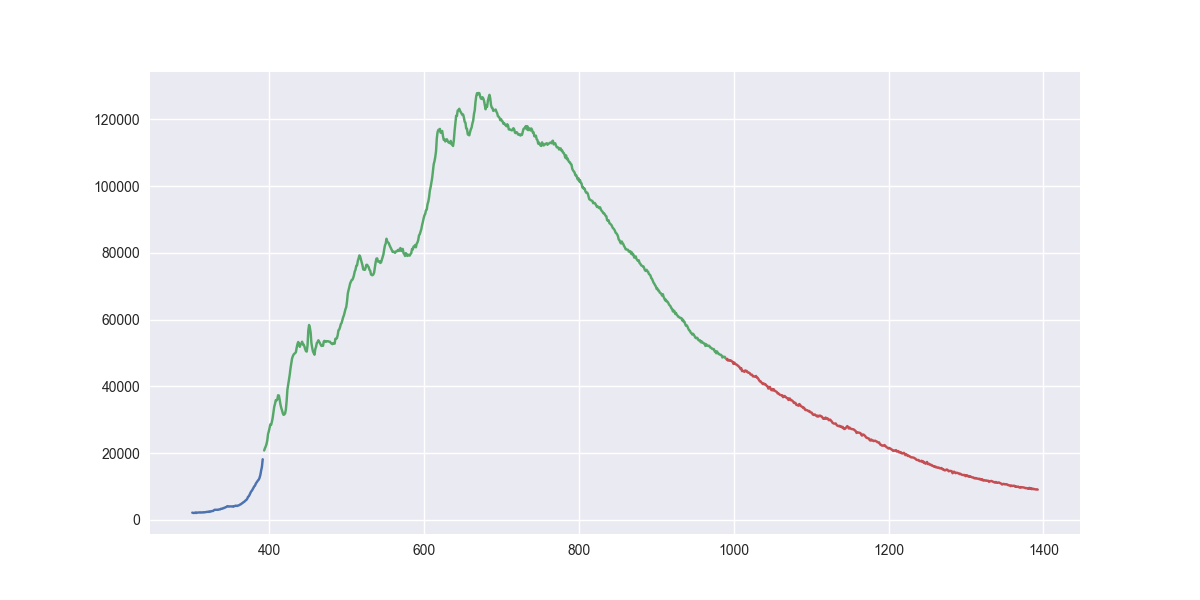

In [42]:
lc1bin = lc1.rebin(1.0)
lc2bin = lc2.rebin(1.0)
lc3bin = lc3.rebin(1.0)

plt.figure(figsize=(12,6))
plt.plot(lc1bin.time, lc1bin.counts)
#plt.plot(lc2.time, lc2.countrate)
plt.plot(lc2bin.time, lc2bin.countrate)
plt.plot(lc3bin.time, lc3bin.counts)

In [43]:
lc = lc1bin.join(lc2bin)
lc = lc.join(lc3bin)

lc.gti = np.array([[lc.gti[0,0], lc.gti[-1,-1]]])

ps = Powerspectrum(lc)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


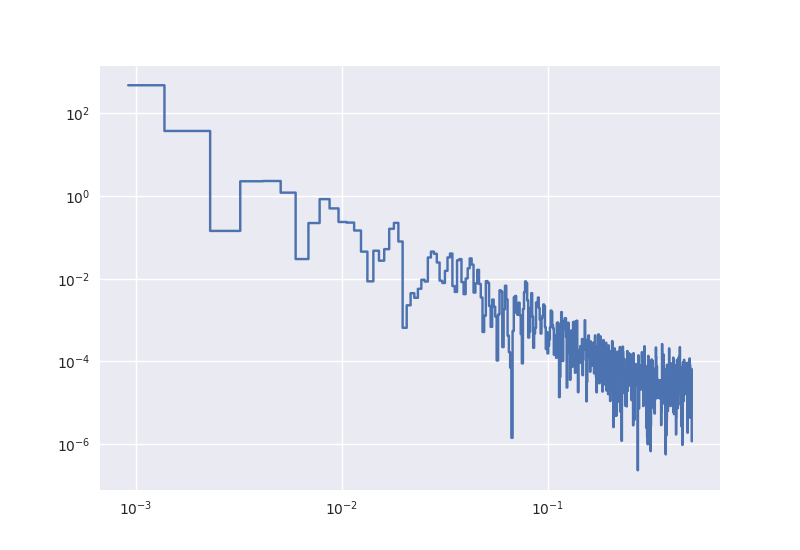

In [44]:
plt.figure()
plt.loglog(ps.freq, ps.power, linestyle="steps-mid")

Let's save the data from this flare as well:

In [46]:
np.savetxt("120704187_ctime_lc.txt", np.array([lc.time, lc.counts]).T)